### ANN Implementation From Scratch

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
dataset='banknote'
df=pd.read_csv('Dataset/banknote.csv').sample(frac=1.0)
N=len(df)

df=df.fillna(0)
feats=df.columns.values[:-1]
target=df.columns.values[-1]
scaler=MinMaxScaler()
scaler.fit(df[feats])
df[feats]=scaler.transform(df[feats])
df.head()


,Attr_A,Attr_B,Attr_C,Attr_D,Result
123,0.399123,0.587303,0.535581,0.858321,0
692,0.794640,0.932635,0.058539,0.382244,0
838,0.340451,0.633837,0.184630,0.530393,1
1289,0.406197,0.435848,0.223238,0.759791,1
1349,0.393527,0.434688,0.301303,0.859261,1


In [3]:
n_train=int(N*0.85)
_train_df=df.loc[:n_train]
_val_df=df.loc[n_train:]

_train_x=np.array(_train_df[feats],dtype=np.float64)
_train_y=np.array(_train_df[target],dtype=np.float64)
_val_x=np.array(_val_df[feats],dtype=np.float64)
_val_y=np.array(_val_df[target],dtype=np.float64)


### Neural Network :
<ul style="list-style-type:none;">  
   <li><b> Forward Propagation : </b></li>
          <ul>
          <li> Output of a neuron : Z = W*X + B , Mentioned as Neuron Output </li>
            <ul style="list-style-type:circle;">
            <li> W(a,b) a for current layer, b for previous layer </li>
            <li> Layer1:Z11 = Node1:W11 * X1 + Node2:W12 * X2 + Layer2:Bias </li>
            <li> Layer1:Z12 = Node1:W11 * X1 + Node2:W12 * X2 + Layer2:Bias </li>
            <li> Layer1:Z13 = Node1:W11 * X1 + Node2:W12 * X2 + Layer2:Bias </li>
            </ul>
          <li>(For detail better under understanding mutual weight indexing W(a,b) see appendix on Nodes)</li>
          </ul>
<li><b>  Calulating gradients : </b></li>
          <ul>          
          <li> Calculatin dE/dW </li>
             <ul>
             <li> dE/dW = dE/dA * dA/dZ * dZ/dw 
             </ul>
          <li> Calculatin dE/dA </li>
                <ul>
                <li>dE/dA : For Last Layer, if loss function is mean square error, then E = 1/2*(Y - A)^2 so , dE/dA = (A-Y) </li>
                <li> dE/dA : For Other Layers dE/dA will be inherited from the each of the node of next layer acccording
                to mutual weights. </li>
                <li> Layer2:Error1 = layer3:Error1 * Layer3:W11 + Layer3:Error2 * Layer3:W21 </li>
                <li> Mathmetically Implmented as Error_l2 = Weights_l3.Transpose() * Error_l3 </li>
                </ul>
          <li>Calculating dA/dZ (dA/dZ : grad of Activation Output wrt each Neuron output  also mentioned as delta here) </li>
                <ul>
                <li> For last layer Derivative of sigmoid function in : dA/dZ = A*(1-A)
                <li> For other layers : dA/dZ = 1
                </ul>
          <li> Calculating dZ/dW (dZ/dW : grad of Neuron Output wrt each weights ) </li>
                 <ul>
                 <li> As Z = W*X + b so dZ/dW = X , for first layer, X is the input  </li>
                 <li> For other layers As Z = W*A + b so dZ/dW = A, here A is the activation value from previous layer. </li> 
                 </ul>
          </ul>
<li><b>  Updating Weights: </b></li>
    <ul>
    <li> Updating each weights W = W - lr*dE/dW </li>
    <li> Here lr is the learning rate. </li>
    </ul>  
<li><b> Note : </b></li> In the flowchart Gradient calcultion & Back Propagation is shown in back propagation.
</ul>

In [4]:
class sigmoid():
    def apply(x):
       y=np.exp(-1*x)+1
       y=1/y
       #print(y)
       return y
    def deriv(x):
        return x*(1-x)
    
class none():  
    def apply(x):
        return x
    def deriv(x):
        return 1
    
class relu():
    def apply(x):
        return x
    def deriv(x):
        deriv=x.copy()
        deriv[x<=0]=0
        deriv[x>0]=1

        return deriv

class Layer():
    
    def __init__(self,name='no_name',pnd=1,nd=0,act_func=none):
        self.name=name
        self.value=np.zeros((nd),dtype=np.float64)
        self.activation=np.zeros((nd),dtype=np.float64)
        #self.weights=np.random.random(size=(nd,pnd))*2.0-1.0
        self.weights=np.random.random(size=(pnd,nd))*2.0-1.0
        self.delta=np.zeros((nd,pnd),dtype=np.float64)
        self.deriv=np.zeros((nd,pnd),dtype=np.float64)
        self.error_deriv=np.zeros((nd),dtype=np.float64)
        self.act_func  = act_func
        
    def __call__(self,_input):
         if self.name=='Input':
                self.activation=_input
         else:
             #self.value=np.matmul(self.weights,_input)
             self.value=np.matmul(_input,self.weights)
             self.activation=self.act_func.apply(self.value)
         return self.activation
        
    def printl(self):
        print(self.name,end=' ')
        print('Node',self.weights.shape[1])
    
    @property
    def act_deriv(self):
        return self.act_func.deriv(self.activation)


class Network(list):
    
    def add(self,_layer):
        _layer.printl()
        self.append(_layer) 
        
    def for_prop(self,_input):
        for j in range(len(self)):
            Layer=self[j]
            out=Layer(_input)
            _input=out
        return out

    def back_prop(self,expected):
        for j in reversed(range(1,len(self))):
            Layer=self[j]
            Prev_Layer=self[j-1]
            
            if Layer.name=='Output':
                error = (expected - Layer.activation)**2
                Layer.error_deriv=2*(Layer.activation-expected.reshape(Layer.activation.shape[0],-1)) # dE/dA

            else :
                Next_Layer=self[j+1]
                weights=Next_Layer.weights.T
                Layer.error_deriv=np.matmul(Next_Layer.error,weights)

            Layer.deriv=Layer.act_deriv*Layer.error_deriv #dE/dA * dA/dZ
            batch_size=Layer.activation.shape[0]
            Layer.delta=np.zeros_like(Layer.weights)
            for i in range(batch_size):                                        # For each sample in batch
                for k in range(Layer.deriv.shape[1]):
                    Layer.delta[:,k] += Prev_Layer.activation[i,:]*Layer.deriv[i,k] #dZ/dW * (dE/dA * dA/dZ)

            Layer.delta /= batch_size
        return err

    def weight_update(self,alpha=0.01):
        for j in range(1,len(self)):
            Layer=self[j]
            Layer.weights-=alpha*Layer.delta

In [5]:
error_log=np.zeros((100),np.float64)
epoc_val=np.zeros((100),np.float64)
     

net=Network()
_layer=Layer('Input',0,len(feats))
net.add(_layer)
#_layer=Layer('Hidden_one',len(feats),3,act_func=relu)
#net.add(_layer)
_layer=Layer('Output',len(feats),1,act_func=sigmoid)
net.add(_layer)

Input Node 4
Output Node 1


In [6]:
#net=network()
from tqdm import tqdm
_no_epochs=100
_epoch=np.zeros((_no_epochs),np.int64)
_error=np.zeros((_no_epochs,2),np.float64)
batch_size=32
for epoch in tqdm(range(1,_no_epochs)):
    err=0
    for i in range(len(_train_x)//batch_size):
        
        _x_batch=_train_x[i*batch_size:(i+1)*batch_size]
        _y_batch=_train_y[i*batch_size:(i+1)*batch_size]
        
        net.for_prop(_x_batch)
        net.back_prop(_y_batch)
        net.weight_update()
        #net=updateWeights(net,X[i],.05)
        #_,pred_tr_Y=for_prop(net,_X_batch.T)
        _pred_y_batch=net.for_prop(_x_batch)
        train_error=np.array((_y_batch-_pred_y_batch)**2).mean() #for j in range(len(Y[i]))
        
        
        _x_batch_val=_val_x#[rind:rind+batch_size]
        _y_batch_val=_val_y#[rind:rind+batch_size]
        pred_val_y=net.for_prop(_x_batch_val)
        val_error=np.array((_y_batch_val-pred_val_y)**2).mean() #for j in range(len(Y[i]))
        #print(epock)
        #print(e)
        _epoch[epoch-1]=epoch
        _error[epoch-1,0]=train_error
        _error[epoch-1,1]=val_error
_epoch[epoch]=epoch
_error[epoch,0]=train_error
_error[epoch,1]=val_error
#print(sigmoid_deriv(.93))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:11<00:00,  8.42it/s]


In [7]:
(_y_batch_val-pred_val_y).shape

(1091, 1091)

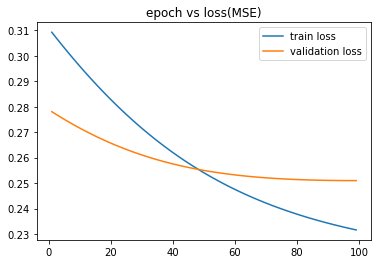

In [8]:
plt.plot(_epoch[0:],_error[0:])
plt.savefig(dataset+' ann_loss')
plt.title('epoch vs loss(MSE)')
plt.legend(['train loss','validation loss'])
plt.show()
#_,v=for_prop(net,X.T)
#print(v)

In [9]:
ret=net.for_prop(_val_x)
ret=ret.reshape(-1).copy()
ret[ret>=0.4]=1.0
ret[ret<0.4]=0.0

In [10]:
print('accuracy',np.sum(ret==_val_y)/len(_val_y))
result_log=pd.DataFrame({})
result_log['true']=_val_y
result_log['pred']=ret
result_log['right']=np.array((ret==_val_y),dtype=np.uint8)
result_log['wrong']=np.array((ret!=_val_y),dtype=np.uint8)

accuracy 0.45187901008249315


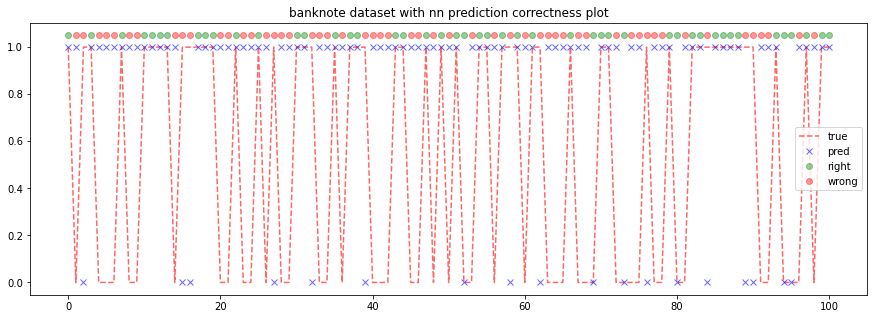

In [11]:
from matplotlib import pyplot as plt
#plt.plot(result_log[['right','wrong']])

fig=plt.figure(figsize=(15,5))
plt.plot(result_log.loc[:100,'true'],'r--',alpha=0.6)
plt.plot(result_log.loc[:100,'pred'],'bx',alpha=0.6)
plt.plot(result_log.loc[:100,'right'][result_log.loc[:100,'right']==1]+0.05,'go',alpha=0.4)
plt.plot(result_log.loc[:100,'right'][result_log.loc[:100,'right']==0]+1.05,'ro',alpha=0.4)
#plt.plot(result_log.loc[:100,'right'],'go',alpha=0.3)
plt.legend(['true','pred','right','wrong'])
plt.title(dataset+' dataset with nn prediction correctness plot')# \n right : 1 \n wrong : 0')
plt.savefig(dataset+'_ann_pred.png')
plt.show()

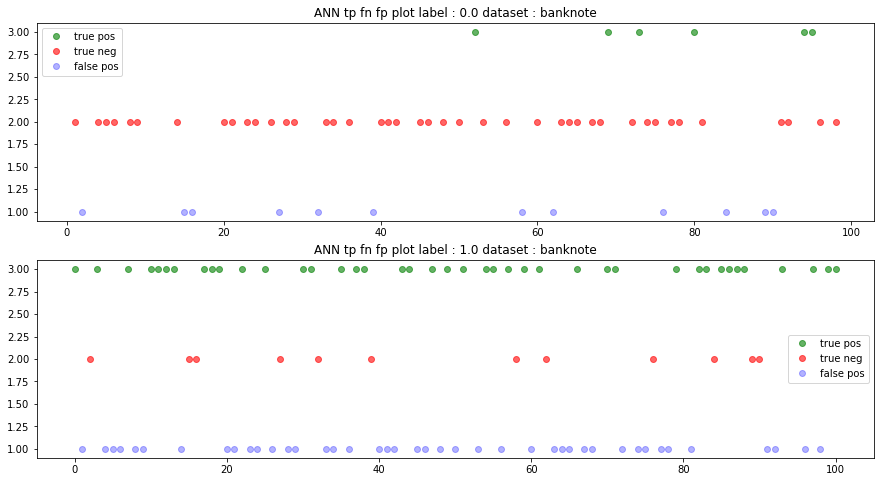

In [12]:
from matplotlib import pyplot as plt
from copy import deepcopy
#plt.plot(result_log[['right','wrong']])
dataset='banknote'

labels=[0.0,1.0]
result_grps=result_log.groupby('pred')
fig,axes=plt.subplots(nrows=len(labels),figsize=(15,8))
for i,label in enumerate(labels):
    
    #_ndf=result_grps.get_group(label)
    ndf= deepcopy(result_log.loc[:100])
    ndf['tp']=np.array(((ndf.true==label) & (ndf.pred==label)),dtype=np.uint8)
    ndf['fn']=np.array(((ndf.true==label) & (ndf.pred!=label)),dtype=np.uint8)
    ndf['fp']=np.array(((ndf.true!=label) & (ndf.pred==label)),dtype=np.uint8)

    ndf['final']=np.array(['None']*len(ndf),dtype=np.object)
    #ndf.final[ndf.tp==1]='True_Pos'
    #ndf.final[ndf.tn==1]='True_Neg'
    #ndf.final[ndf.fp==1]='False_Pos'

    #plt.plot(ndf.index,ndf.final)
    axes[i].plot(ndf.tp[ndf.tp==1]*3,'go',alpha=0.6)
    axes[i].plot(ndf.fn[ndf.fn==1]*2,'ro',alpha=0.6)
    axes[i].plot(ndf.fp[ndf.fp==1]*1,'bo',alpha=0.3)
    #plt.plot(result_log.loc[:100,'right'][result_log.loc[:100,'right']==0]+1.05,'ro',alpha=0.3)
    #plt.plot(result_log.loc[:100,'right'],'go',alpha=0.3)
    axes[i].legend(['true pos','true neg','false pos'])
    axes[i].set_title('ANN tp fn fp plot label : '+str(label)+' dataset : '+dataset)# \n right : 1 \n wrong : 0')
plt.savefig(dataset+'tp_fp.png')
plt.show()

In [13]:
total=len(result_log)
acc=result_log.right.sum()#,len(result_log)
accuracy=acc/total
labels=result_log['true'].unique()
ldf=pd.DataFrame(data={},index=[' '])
precisions={}
recalls={}
for label in labels:
    true_ind=result_log['true']==label
    false_ind=result_log['true']!=label
    Yes=result_log.loc[true_ind]
    No=result_log.loc[false_ind]
    tp=Yes.right.sum()
    tn=No.right.sum()
    fn=Yes.wrong.sum() #wrong after negative prediction means positive
    fp=No.wrong.sum() #wrong after positive prediction means negative
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    precisions[label]=precision
    recalls[label]=recall
    print('----------------------')
    print('label',label)
    print('precision',precision)
    print('recall',recall)
    print('----------------------')
print('Over All Accuracy : ',accuracy)

----------------------
label 1.0
precision 0.4344059405940594
recall 0.7134146341463414
----------------------
----------------------
label 0.0
precision 0.5017667844522968
recall 0.2370617696160267
----------------------
Over All Accuracy :  0.45187901008249315


In [14]:
import pandas as pd
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)

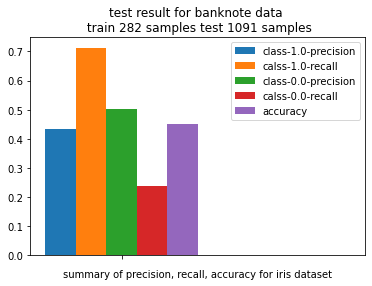

In [15]:
df=pd.DataFrame({},index=[' '])
#fig=plt.figure(figsize=(10,10))
for label in result_log['true'].unique():
    df['class-'+str(label)+'-precision']=[precisions[label],]
    df['calss-'+str(label)+'-recall']=[recalls[label],]
df['accuracy']=accuracy 
df.plot.bar()
plt.xlim(-.3,.8)
plt.title('test result for ' +dataset+ ' data \n '+'train '+str(len(_train_df))+' samples test '+str(len(result_log))+' samples')
plt.xlabel('summary of precision, recall, accuracy for iris dataset')
plt.savefig(dataset+'_ann.png')
plt.show()

<h4> Nodes : </h4>
<div style="background-color:#F8F9F9">
    <ul style="list-style-type:square;">  
    <li> Every Node/Neuron is considered to have weights for each of previous layers node.</li>
    </ul>
         <br>Leyer 1 ->2 nodes 
         <br>Layer 2 ->3 Nodes
         <br>So, Layer 2's each of the 3 Nodes will have two weights for Layer 1's each of the 2 nodes.
         <br>they are -
         <br>Layer 2 - Node 1: W11 , W12
         <br>Layer 2 - Node 2: W21 , W22
         <br>Layer 2 - Node 3: W31 , W32
         <br>Value of Layer 2:Node1 (Z21) = X1 * Layer2:W11 + X2 * Layer2:W12
         <br>Mutual Weights: Layer:W(a,b) : 
             <br>a is the node we are calculating for (current layer)
             <br>b is the contributing node (from previous layer)
             <br>i.e 
              <br>Layer2:W12 --> Layer 2's 1st node's weight for previous layers(Layer 1) 2nd node
              <br>Layer2:W13 --> Layer 2's 1st node's weight for previous layers(Layer 1) 3rd node

</div>

### Extra Debug Codes :

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


C:\Users\irfan\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


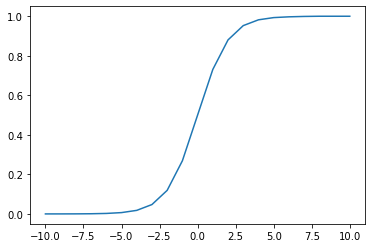

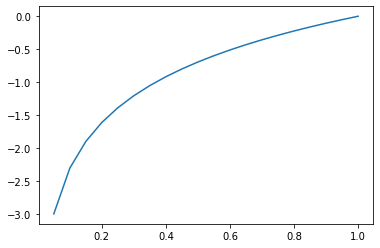

In [16]:
x=np.ones((21),np.int8)
for i in range(0,21):
    x[i]=i-10
y=np.exp(-1*x)
y=1+y
y=1/y
p=(x+10)/20
z=np.log(p)
print(x)
plt.plot(x,y)
plt.show()
plt.plot(p,z)
plt.show()

In [17]:
print(np.argmax([.2,.3]))

1
